In [1]:
# IMPORT EVERYTHING
#from Architectures.AE_ADJ import AE  # for some reason importing this makes it not work? (reconstructs everything around the brain somehow)
from Architectures.AE_ADJ_v2 import AE  # for some reason importing this makes it not work? (reconstructs everything around the brain somehow)

from Data.load import load, load_middle_slices
from Visualizations.latent_space_projections import pPCA, pTSNE, pUMAP, pISOMAP, pENCODED, plot_multiple_datasets
from Visualizations.plots import plot_middle_slices_in_range, plot_models_training_time, compare_models_loss_history, plot_images, compare_models_reconstruction
from Metrics.metrics_tf import MSE_loss, NMSE_loss, NRMSE_loss, SSIM_loss
from Metrics.metrics import NMSE, SSIM, NRMSE, MSE

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers, Model, activations, regularizers
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from skimage.metrics import structural_similarity as ssim

import umap
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd
import seaborn as sns
import glob
import tensorflow as tf
import time
import math
import nibabel as nib
import json
from tqdm import tqdm

c:\Users\kiran\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
groups = {}
for group in tqdm(["CN","MCI","AD"],"Opening faster"):
    groups[group]=np.load(open(f"Data/D2-{group}-A.npy","br"))

Opening faster: 100%|██████████| 3/3 [00:00<00:00, 27.48it/s]


In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, Model
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the sampling function for the reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, logvar = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * logvar) * epsilon

# Define the VAE model
class AE(keras.Model):
    def __init__(
            self,
            input_shape,
            latent_dim,
            encoder_layers,
            decoder_layers,
            name="AE",
            VAE_model=True,
            beta=1,
            debug=False,
            hidden_activation=activations.leaky_relu,
            loss_fn="mse",
            optimizer="adam",
            ):
        super(AE, self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.VAE_model = VAE_model
        self.name = name
        self.beta = beta
        
        self.history = None
        self.debug = debug
        self.hidden_activation = hidden_activation
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        #self.GPU = GPU

        self.hist = {'loss': [], 'val_loss': [], 'reconstruction_loss': [], 'kl_loss': []}
        
        # shape_changed=False
        #if input_shape[-1]>3:
        #    input_shape = list(input_shape) + [1]
        #    shape_changed=True
        #if len(input_shape)>4:
        #    input_shape = input_shape[-4:]
        #    shape_changed=True
        #if shape_changed: 
        #    print(f"Interpreted image shape: {tuple(input_shape)}")

        if len(self.input_shape) == 4: 
            self.input_shape = (list(self.input_shape) + [1])[-4:] # (8, 80, 96, 80) -> [8, 80, 96, 80, 1] -> [80, 96, 80, 1] 
        if len(self.input_shape) == 3:
            self.input_shape = (list(self.input_shape) + [1])[-3:] # (8, 80, 96) -> [8, 80, 96, 1] -> [80, 96, 1] 
        print(f"Interpreted image shape: {tuple(self.input_shape)}", end=" ")

        # Encoder
        encoder_input_layer = x = layers.Input(shape=self.input_shape)
        x = self.add_layers(x, self.encoder_layers)
        pre_flatten_shape = x.shape
        x = layers.Flatten()(x)
        print(f"Pre-flattened latent shape: {pre_flatten_shape}")
        
        # VAE specific: Output mean and log variance
        if self.VAE_model:
            self.mean = layers.Dense(self.latent_dim, name="mean")(x)
            self.log_var = layers.Dense(self.latent_dim, name="log_var")(x)
            z = Sampling()([self.mean, self.log_var])
            self.encoder = Model(encoder_input_layer, [self.mean, self.log_var, z], name="encoder")
        else:
            x = layers.Dense(self.latent_dim, activation=hidden_activation)(x)
            self.encoder = Model(encoder_input_layer, x, name="encoder")

        # Reshape the latent vector back to the original spatial dimensions
        decoder_input = layers.Input(shape=(latent_dim,))
        x = layers.Dense(np.prod(pre_flatten_shape[1:5]), activation=hidden_activation)(decoder_input)
        x = layers.Reshape(pre_flatten_shape[1:])(x)
        x = self.add_layers(x, self.decoder_layers)
        
        self.decoder = Model(decoder_input, x, name="decoder")

        # 3. Combine the encoder and decoder into a full AE / VAE
        #if self.VAE_model:
        #    mean, log_var, z = self.encoder(encoder_input_layer)
        #    autoencoder_output = self.decoder(z)
        #    self.autoencoder = Model(encoder_input_layer, autoencoder_output, name="autoencoder")
        #    # kl_loss = -0.5 * tf.reduce_mean(
        #    #     1 + log_var - tf.square(mean) - tf.exp(log_var)
        #    # )            
        #    # total_loss = reconstruction_loss + kl_loss
        #else:
        #    autoencoder_output = self.decoder(self.encoder(encoder_input_layer))
        #    self.autoencoder = Model(encoder_input_layer, autoencoder_output, name="autoencoder")
        #
        ##self.autoencoder.compile(optimizer=keras.optimizers.Adam(), loss="mse")
    
    def add_layers(self, x, layers):
        for layer in layers:
            
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
        
            if self.debug:
                print(f"After {x.shape}: {layer}")
        return x
    
    def train(self, x_train, epochs=2, batch_size=16, verbose=False, save_path="", save_interval=100, patience=100):
        """A seperate train function to save models every n interval and do other usefull modifications"""
        start_time = time.time()        
        
        if save_path:
            os.makedirs(save_path, exist_ok=True)

        print(f"Training {self.name} on CPU") #{'GPU' if self.GPU else 'CPU'}")
        print(f"Input shape: {x_train.shape}")

        best_val_loss = float('inf')
        wait = 0
        best_model_weights = None  # Store the best model's weights

        for epoch in range(1, epochs + 1):
            history = self.fit(
                x_train, x_train,
                epochs=1,
                batch_size=batch_size,
                shuffle=True,
                validation_split=0.2,
                verbose=verbose
            )
            
            self.hist["loss"].extend(history.history["loss"])
            self.hist["val_loss"].extend(history.history["val_loss"])
            self.history = self.hist

            # usefull if you want to track progress
            if save_path and epoch % save_interval == 0:
                self.save(save_path, name=f"{self.name}", verbose=verbose)
            
            # save weights of the best model
            val_loss = history.history["val_loss"][0]
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_weights = self.get_weights()
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping at epoch {epoch} due to no improvement in val_loss for {patience} epochs.")
                    break
        
        # After training, save the best model
        if best_model_weights is not None and save_path:
            self.set_weights(best_model_weights)  # Restore the best model weights
            self.save(save_path, name=f"{self.name}", verbose=verbose)

        self.training_time = time.time() - start_time
        print(f"Training complete in {round(self.training_time, 2)}s")
        return self.history

    def call(self, inputs):
        if self.VAE_model:
            z, mu, logvar = self.encoder(inputs)
            reconstructed = self.decoder(z)
            kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar)) * self.beta
            self.add_loss(kl_loss)
        else:
            reconstructed = self.decoder(self.encoder(inputs))
        return reconstructed
    
    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)
    
    def autoencode(self, x):
        """Encode and decode again"""
        latent = self.encode(x)
        if self.VAE_model:
            latent = latent[2]
        recon = self.decode(latent)
        recon = np.squeeze(recon, axis=-1) #((0,0,0,0)) -> ((0,0,0))
        return recon

    # Sacred meme, do not delete
    # def compile(self):
    #    self.compile(optimizer=self.optimizer, loss=self.loss, metrics=None)
    
    def compile_model(self):
        self.compile(optimizer=self.optimizer, loss=self.loss_fn)
        return self

    def save(self, model_path, name="AE_test", verbose=False):
        """Save the VAE model, encoder, and decoder to disk."""
        model_folder = os.path.join(model_path, f"{name}")
        epoch_folder = os.path.join(model_folder, "epoch_"+str(len(self.hist["loss"])))
        os.makedirs(model_folder, exist_ok=True)
        os.makedirs(epoch_folder, exist_ok=True)

        self.encoder.save(os.path.join(epoch_folder, "encoder.keras"))
        self.decoder.save(os.path.join(epoch_folder, "decoder.keras"))
        if verbose:
            print(f"Models saved to {epoch_folder} as '{name}_autoencoder.keras', '{name}_encoder.keras', '{name}_decoder.keras'.")

        
        # Save loss history if available
        if self.history is not None:
            history_path = os.path.join(epoch_folder, "history.json")
            with open(history_path, 'w') as f:
                json.dump(self.hist, f)
            if verbose:
                print(f"Loss history saved to {history_path}")

        configs = {
            "input_shape": str(self.input_shape),
            "latent_dim": str(self.latent_dim),
            "encoder_layers": str(self.encoder_layers),
            "decoder_layers": str(self.decoder_layers),
            "name": str(name),
            "VAE_model": str(self.VAE_model),
            "beta": str(self.beta),

            "loss_fn": str(self.loss_fn) if type(self.loss_fn) is str else str(self.loss_fn.__name__),
            "debug": str(self.debug),
            "hidden_activation": str(self.hidden_activation),
            "optimizer": str(self.optimizer)
        }

        # Save the model details (converted to strings) in a JSON file
        configs_path = os.path.join(epoch_folder, "configs.json")
        with open(configs_path, 'w') as f:
            json.dump(configs, f, indent=4)
        if verbose:
            print(f"Model details saved to {configs_path}")
  
    @staticmethod
    def open(path):
        """Load the VAE model, encoder, and decoder from disk."""
        encoder = tf.keras.models.load_model(os.path.join(path, "encoder.keras"), custom_objects={'Sampling': Sampling})
        decoder = tf.keras.models.load_model(os.path.join(path, "decoder.keras"))
        
        # Create an instance of VAE without initializing models
        ae = AE.__new__(AE)
        ae.encoder = encoder
        ae.decoder = decoder

        with open(os.path.join(path, "history.json")) as f:
            ae.hist = json.load(f) #ae.history = {'loss': [], 'val_loss': []}  
            ae.history = ae.hist
        

        ae.name="ok"
        ae.built = True # I should have used .h5 file types so this small hack wouldnt be needed (it allows me to load and continue training the model for testing)

        print("Models loaded successfully.")

        with open(os.path.join(path, "configs.json")) as f:
            ae.details = json.load(f)
            
            # Ensure these are boolean values, convert them if necessary # [False, True]["False" == "True"]
            ae.input_shape = eval(ae.details["input_shape"])
            ae.latent_dim = eval(ae.details["latent_dim"])
            ae.encoder_layers = ae.details["encoder_layers"]
            ae.decoder_layers = ae.details["decoder_layers"]
            ae.name = ae.details["name"]
            ae.VAE_model = eval(ae.details["VAE_model"])
            ae.beta = eval(ae.details["beta"])
            ae.loss_fn = {"MSE_loss": MSE_loss, "SSIM_loss": SSIM_loss, "NMSE_loss": NMSE_loss, "NRMSE_loss": NRMSE_loss}[ae.details["loss_fn"]] 
            ae.debug = eval(ae.details["debug"])
            
            ae.hidden_activation = str(ae.details["hidden_activation"]), #eval(ae.details["hidden_activation"]),
            ae.optimizer = str(ae.details["optimizer"]),
        
        # Now reassemble the full VAE model and compile
        #vae.full_model = vae.create_full_model()  # Assuming you have a method to create the full model
        #vae.full_model.compile(optimizer='adam')  # Compile the full model after loading components
        #vae.compile(optimizer="adam")
        #vae._compile_loss = None
        #vae._compile_metrics = None
        #vae._loss_tracker = None
        #super(VAE, vae).compile(optimizer="adam", loss="mse", metrics=None)

        return ae


In [4]:
"""
A2 = AE(name="A2", input_shape=groups["CN"].shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 16, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
        (layers.Conv2D, 32, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
    ],
    decoder_layers=[
        (layers.Conv2D, 32, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 16, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1, (3,3), {'padding': 'same'}),
    ], VAE_model=False, optimizer="adam", loss_fn="mse").compile_model()
"""

public_repo = AE(name="public_repo", input_shape=groups["CN"].shape, latent_dim=128,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1,  (3, 3), {'activation': 'sigmoid','padding': 'same',}),
    ],
    VAE_model=False, optimizer="adam", loss_fn=MSE_loss).compile_model()

Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 20, 24, 128)


In [5]:
train = groups["CN"]
for m in [public_repo]: #[A2,A4,A5]
    m.train(train, epochs=1000, batch_size=128, verbose=True, 
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images", 
    save_interval=1000, patience=30)

Training public_repo on CPU
Input shape: (988, 80, 96)
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.1082 - val_loss: 0.0490
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0413 - val_loss: 0.0185
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0183 - val_loss: 0.0148
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0154 - val_loss: 0.0136
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0147 - val_loss: 0.0131
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0142 - val_loss: 0.0126
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0139 - val_loss: 0.0126
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0139 - val_loss: 0.0126
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0138 - val_loss: 0.0127
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0138 - val_loss: 0.0126
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0136 - val_loss: 0.0128
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0139 - val_loss: 0.0124
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0135 - val_loss: 0.0122
7/7 ━━━━━━━━━━━━━━━━━━

In [6]:
#models_list = [AE.open(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\A2\epoch_699")]

models_list = [AE.open(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_repo\epoch_109")]

Models loaded successfully.


In [7]:
y_pred = models_list[0].autoencode(train) #models_list[0]

c = SSIM_loss(train, y_pred).numpy()
c = MSE_loss(train, y_pred).numpy()
c

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


0.0061676755498364395

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
(96, 80) (96, 80)


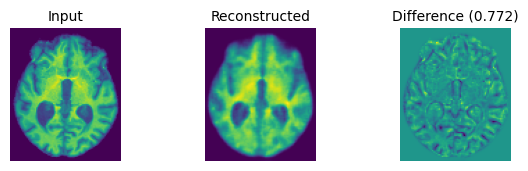

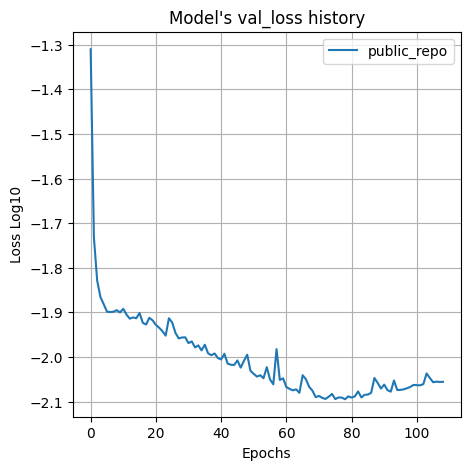

In [8]:
#models_list2d = [E5] #[A9,A6,A7] #[E,E2] #, B0, B1, B2]

#models_list = models_list2d

if 'models_list' in locals(): # if the variable exists
    images, latent, titles = compare_models_reconstruction(brain_scan_id=0, models_list=models_list, test=groups["CN"], loss=SSIM) # remember to update options [test, test2d]
    #print(latent)
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=titles, top_title="")
    
    plot_models_training_time(models_list, fig_size=(5,5))
    compare_models_loss_history(models_list, log10=True, fig_size=(5,5))


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step


c:\Users\kiran\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step


c:\Users\kiran\anaconda3\Lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\kiran\anaconda3\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\kiran\anaconda3\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\kiran\anaconda3\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\kiran\anacon

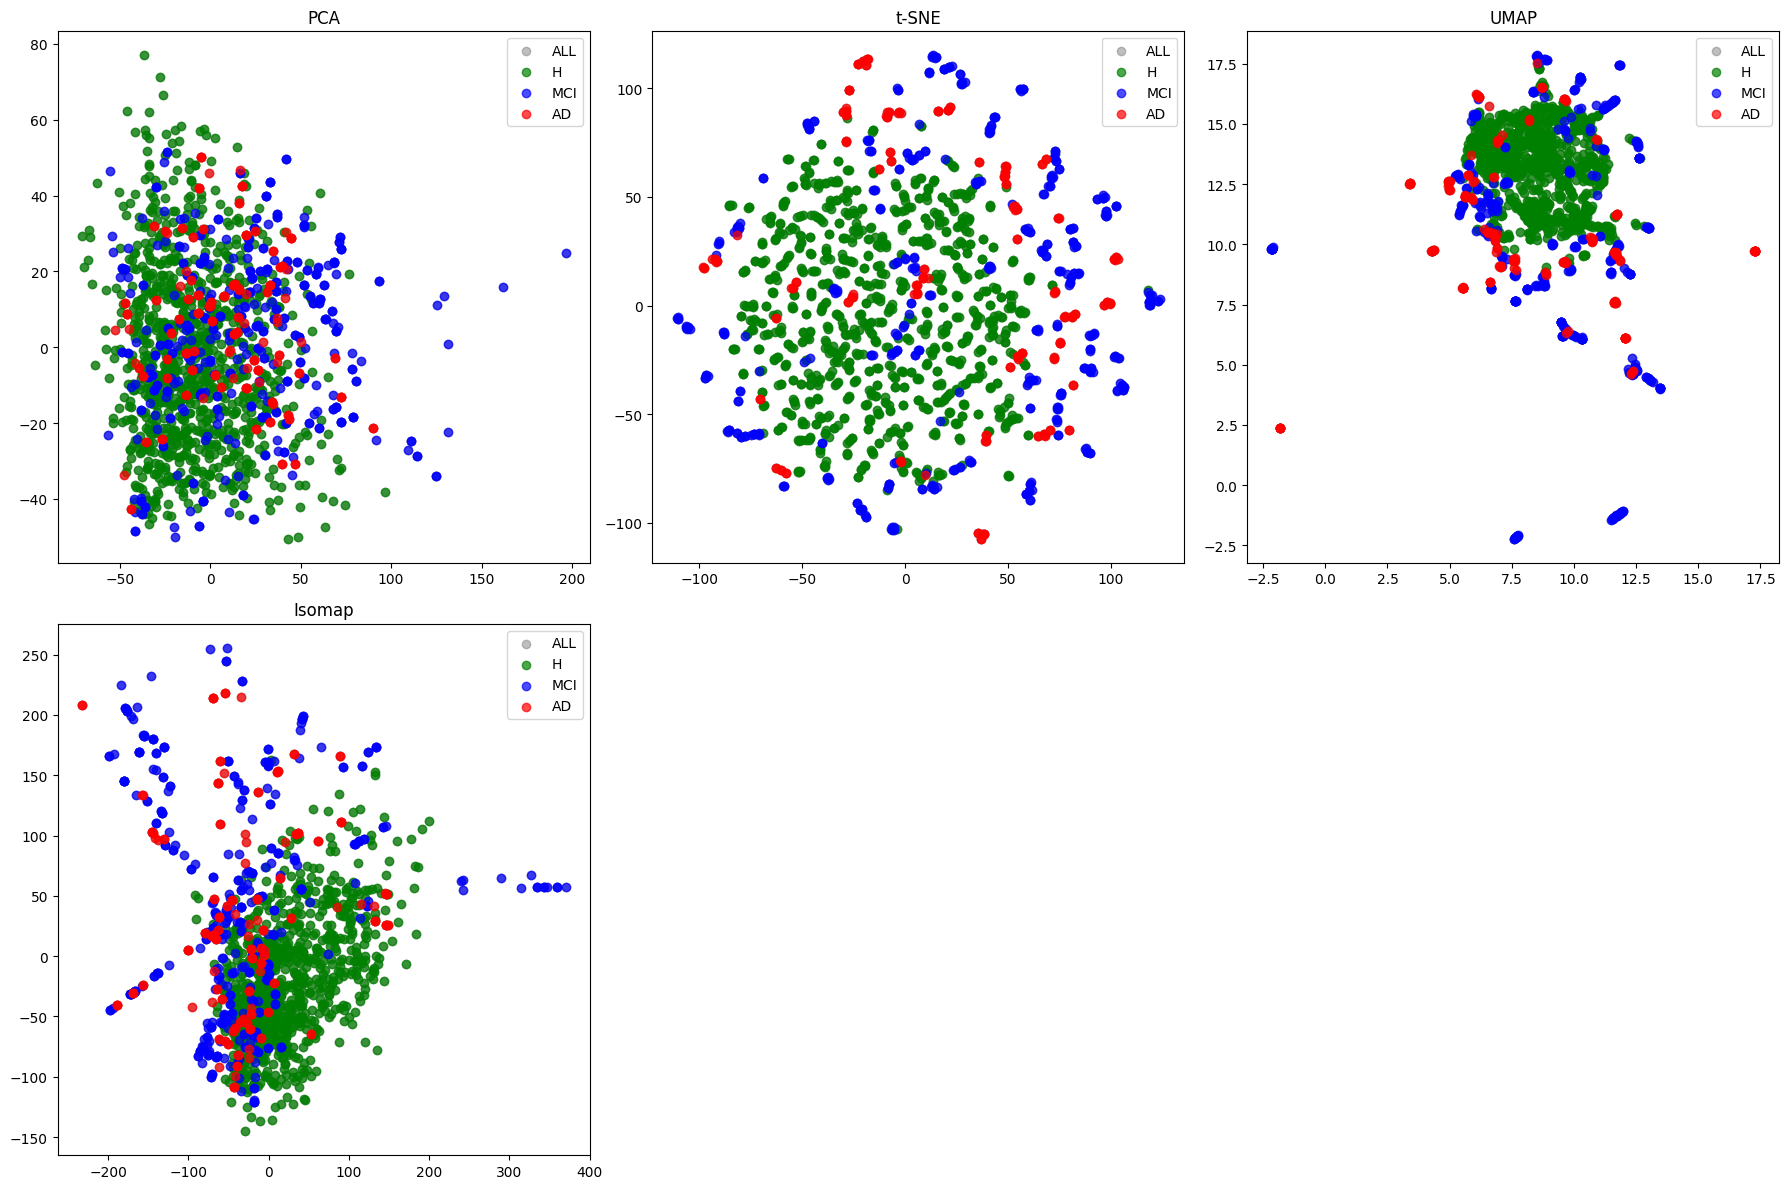

In [9]:
for m in models_list:
    plot_multiple_datasets( 
        model=m,
        plot_functions=[pPCA, pTSNE, pUMAP, pISOMAP],
        datasets=[groups["CN"], groups["MCI"], groups["AD"]],
        labels=["H", "MCI", "AD"],
        colors=["green", "blue", "red"],#, "green", "blue"],
        titles=["PCA", "t-SNE", "UMAP", "Isomap"]
    )
